# Ensemble : Boosting

## 1.환경준비

### (1) import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from xgboost import XGBClassifier, plot_tree # XGB 분류기 (얘는 sklearn 아님)
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

### (2) 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)


In [2]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(5000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


## 2.데이터 준비

### (1) 데이터 정리

In [3]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

### (2) 데이터분할1 : x, y 나누기

In [4]:
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [5]:
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (5) 데이터분할2 : train : validation

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 2022)

## 3.모델링 : XGB

In [12]:
# 모델 선언 (sklearn 함수 선언과 동일)
model = XGBClassifier(n_estimators = 5, max_depth=3)

In [13]:
# 학습
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [14]:
# 예측
pred = model.predict(x_val)

In [15]:
# 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       769
           1       0.70      0.69      0.70       731

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



## 4.시각화와 변수중요도

### (1) 모델 시각화

xgboost 자체 plot_tree 함수를 제공합니다. 

* plot_tree(model, num_trees = 0)
    * num_trees : 전체 트리 5개짜리 모델이므로 각각 0~4까지 인덱스로 조회해 볼 수 있다.

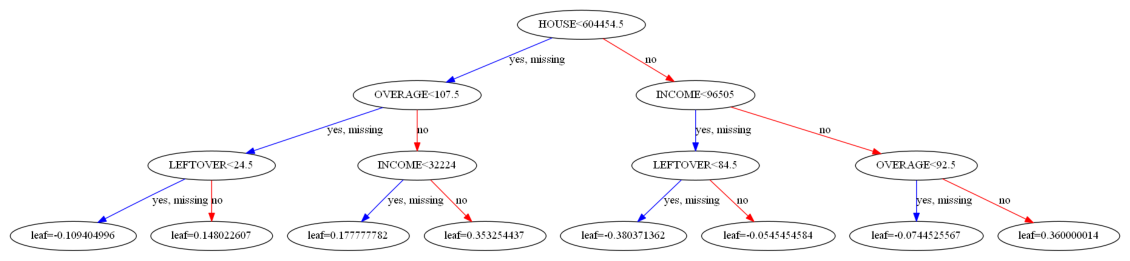

In [16]:
plt.rcParams['figure.figsize'] = 20,20 #트리 크기 조정 => 영향은 파일 전체에
# 모든 그래프 크기가 20, 20으로 고정된다.

plot_tree(model, num_trees = 0) # xgboost에 딸려있는 함수
# tree를 5개 만들었어, num_trees=0은 제일 첫번째 모델을 보여줘

plt.show()

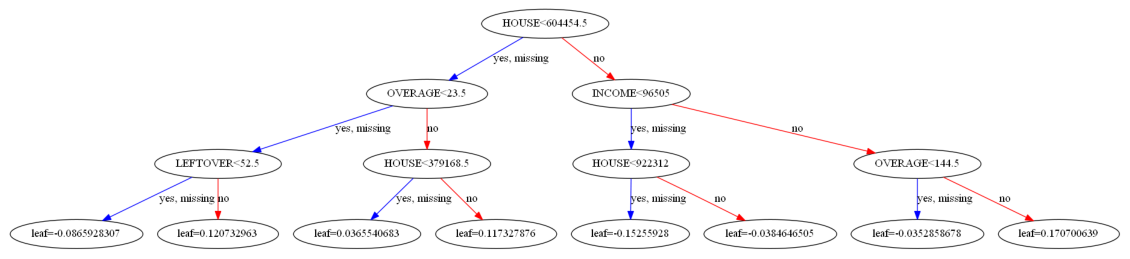

In [17]:
plot_tree(model, num_trees = 4) #얘는 맨 끝에 있는 모델
plt.show()

# 위와 아래 모델 모양새가 다른 이유는 서로 다른 모델이니깐.
# 5개 제각각인 트리를 더해서 뭔가 상상? 좀 불가능
# 여기서는 5개니까 시도라도 가능
# 디폴트인 100개라면 좀 불가능


### (2) 변수 중요도

In [19]:
# 변수 중요도
print(x_train.columns)
print(model.feature_importances_) #DT도, RandomForest도, XGBoost도 이름이 똑같

# depth=3짜리 만들었으니까 몇 개 안보이는 것

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat',
       'REPORTED_USAGE_LEVEL_high', 'REPORTED_USAGE_LEVEL_little',
       'REPORTED_USAGE_LEVEL_very_high', 'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')
[0.         0.23316367 0.23149604 0.18991315 0.28209737 0.
 0.06332982 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


* 변수중요도 그래프 그리기 함수 만들기

In [20]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

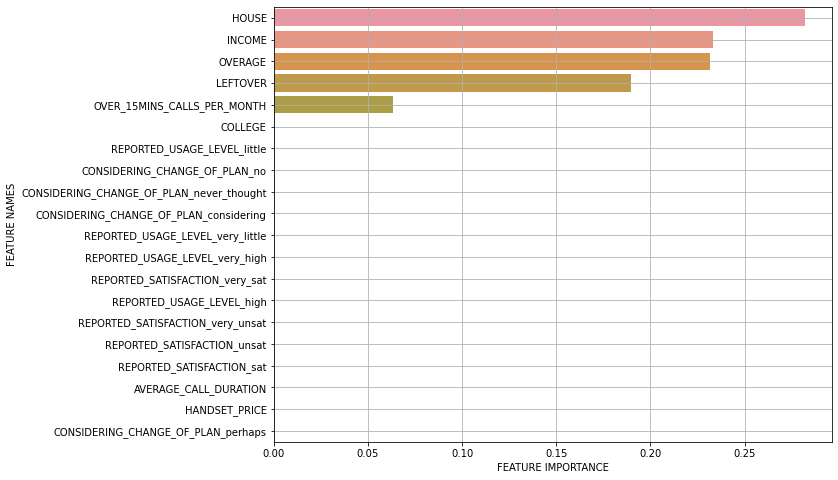

In [21]:
result = plot_feature_importance(model.feature_importances_, x_train.columns)

# 중요한 변수 추출은 마찬가지로 elbow method 사용

## 5.실습 : 튜닝
* xgboost에 대해 grid search로 튜닝을 수행해 봅시다.
    * cv = 5
    * grid 파라미터
        - max_depth : 3~8 사이에서 3개 선택
        - n_estimators : 50~150 사이에서 3개 선택
        - learning_rate :0.01~ 0.2 사이에서 3개 선택

In [25]:
params = {
    'max_depth' : [3, 5, 8],
    'n_estimators' : [50, 100, 150],
    'learning_rate' : np.linspace(0.1, 0.2, 3)
}

In [26]:
model2 = XGBClassifier()
m_gs2 = GridSearchCV(model2, params, cv=5, verbose=3)

In [27]:
m_gs2.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth

[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=50; total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=150; total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=150; total time=   0.6s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=150; total time=   0.4s
[CV 4/5] END learnin

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...hot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
         

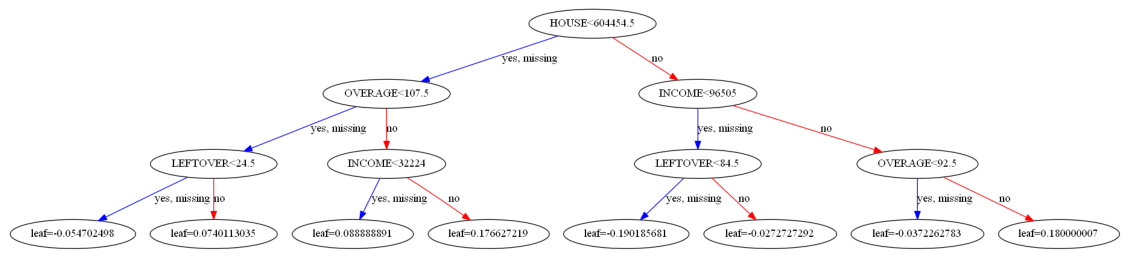

In [43]:
# grid search를 가지고 만든 모델 중에서 가장 성능 좋은 것의
# 첫번째 모델 그려보기
plot_tree(m_gs2.best_estimator_, num_trees=0);
#plt.show()

In [29]:
pred2 = m_gs2.predict(x_val)
print(classification_report(y_val, pred2))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       769
           1       0.68      0.70      0.69       731

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500



* 변수 중요도

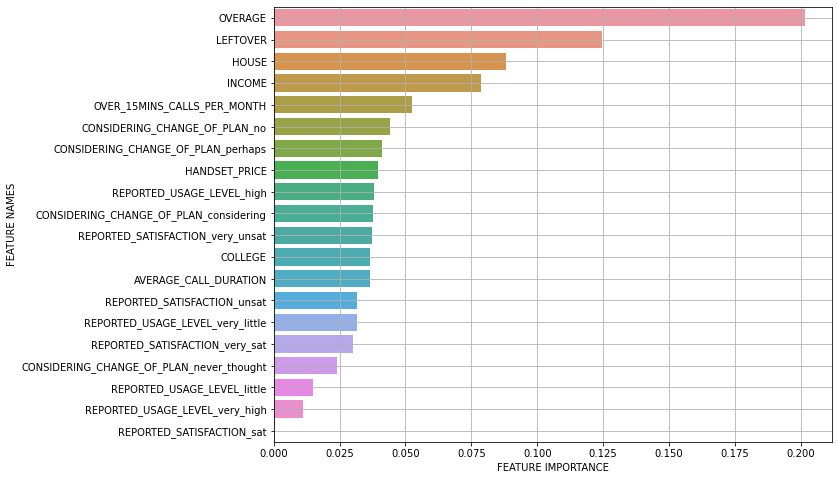

In [35]:
r = plot_feature_importance(m_gs2.best_estimator_.feature_importances_, list(x_train))

## 6.하이퍼파라미터 변화에 따른 성능 추세

### (1) n_estimators
* 1~150까지 증가시켜가며 성능 추세 살펴보기

In [45]:
grid_param = {'n_estimators':range(1,200,2)}
model = XGBClassifier()
model_gs = GridSearchCV(model, grid_param, cv = 3)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [46]:
result = pd.DataFrame(model_gs.cv_results_)

In [47]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_n_estimators','mean_test_score']]
temp.head()

,param_n_estimators,mean_test_score
0,1,0.661712
1,3,0.674854
2,5,0.674856
3,7,0.672855
4,9,0.671428


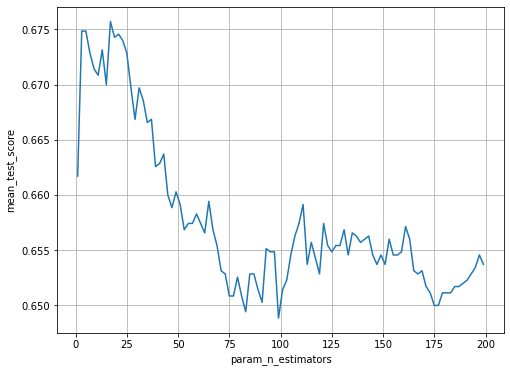

In [48]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_estimators', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

# 오른쪽으로 갈수록 수평선이거나 떨어지지, 더 올라가진 않는다.
# tree가 많아질수록 성능이 오히려 떨어진다.
# y = m1+m2+m3+...+err
# 이 err은 original(train) y와 예측 y의 차이
# train 안에 있는 진짜 구석에 있는 특성까지 발견하면서 과하게 train

#이게 gradient boost가 너무 심하고, xgboost는 좀 보완한거긴한데
# xgboost라고 하더라도 적절한 사이즈 찾는것이 필요

### (2) learning rate
* 0.01 ~ 1까지 증가시켜가며 성능 추세 살펴보기

In [49]:
grid_param = {'learning_rate':np.linspace(0.01,1,100)} #learning_rate은 1을 넘어가지 않음
# 0 < learning_rate <= 1
model = XGBClassifier()
model_gs = GridSearchCV(model, grid_param, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.

In [50]:
result = pd.DataFrame(model_gs.cv_results_)

In [51]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_learning_rate','mean_test_score']]
temp.head()

,param_learning_rate,mean_test_score
0,0.01,0.678857
1,0.02,0.687143
2,0.03,0.685714
3,0.04,0.685143
4,0.05,0.684000


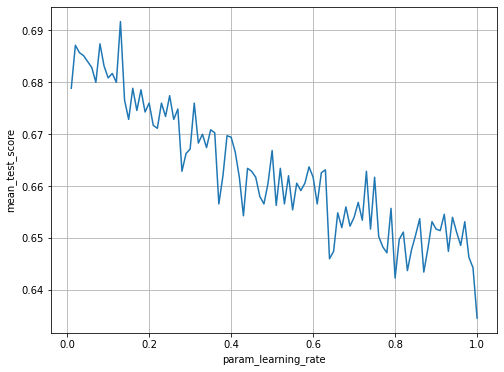

In [52]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_learning_rate', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

# learning_rate의 일반적인 추세
# 좀 올라갔다가 내려가는 추세, 그리고 커지는 구간이 대체로 0.2보다 작음


### (3) n_estimators + learning rate
* 이번에는 두 하이퍼파라미터를 동시에 조절하며 추세를 살펴보겠습니다.
* n_estimators : 30, 50, 100, 150
* learning_rate : 0.05 ~ 0.3까지 0.01씩 증가

In [57]:
grid_param = {'learning_rate':np.linspace(0.001,0.3,50),
              'n_estimators':[20,30,50,100]}
# 모델들의 개수를 결정하는 것이 n_estimators
# 2번째 모델부터 각 모델들에 '에타'값(learning_rate)이 곱해짐

# 너무 learning_rate, n_estimators 너무 크면 뒤의 모델들의 영향이 너무 커지고
# 너무 작으면 너무 적게 올라감

model = XGBClassifier(eval_metric='logloss')
model_gs = GridSearchCV(model, grid_param, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
       0.12304082, 0.12914286, 0.1352449 , 0.14134694, 0.14744898,
       0.15355102, 0.15965306, 0.1657551 , 0.17185714, 0.17795918,
       0.18406122, 0.19016327, 0.19626531, 0.20236735, 0.20846939,
       0

In [58]:
result = pd.DataFrame(model_gs.cv_results_)

In [59]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_n_estimators', 'param_learning_rate','mean_test_score']]
temp.head()

,param_n_estimators,param_learning_rate,mean_test_score
0,20,0.001,0.681143
1,30,0.001,0.680571
2,50,0.001,0.681143
3,100,0.001,0.681714
4,20,0.007102,0.687429


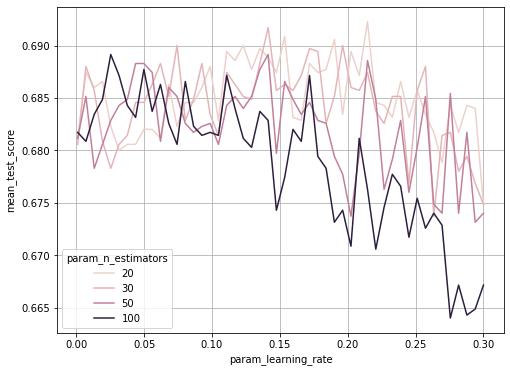

In [60]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_learning_rate', y = 'mean_test_score', data = temp, hue = 'param_n_estimators')
plt.grid()
plt.show()

# learning_rate이 낮을수록 오차를 반영하는 비율이 높은것임
# n_estimators가 높을수록 반복횟수 높은 것